SIR Model: susceptible $S$, infectious $I$, removed $R$
$$
\frac{dS}{dt} = -a S I, \quad 
\frac{dI}{dt} = a S I - b I, \quad
\frac{dR}{dt} = b I 
$$

Parameters are viralence $a$ and removal rate $b$.  
How are these parameters controlled by mask mandates and stay at home orders?

Proceedure:
Fit SIR model to a segment of data.  Do this over each segment of data, and observe how viralence and removal rate change.  Compare with major events (mask mandates, stay at home orders)

In [40]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(1, "../")

import SIR_utils as sir
from get_mask_dates import *

In [41]:
mandate = pd.read_csv('../stay_at_home_and_masks.csv')
def get_date(dataframe, state):
    state = dataframe.loc[dataframe['state'] == state]
    date = np.array(state['mask_date'])[0].split('-')[::-1]
    return date[0] + '-' + date[1] + '-' + date[2]

#print(mandate)

In [42]:
# state = "new-jersey"
# state_abbr = "NJ"
state = "florida"
state_abbr = "FL"
# state = "georgia"
# state_abbr = "GA"
# state = "new-york"
# state_abbr = "NY"

time_dataframe = pd.read_csv("../{}-history.csv".format(state))
#print(time_dataframe)

dates = time_dataframe["date"][::-1]
removed = time_dataframe["positiveCasesViral"][::-1]
indices = np.array(1 - np.isnan(removed)).astype(np.bool)

dates = np.array(dates)[indices]
rem = np.array(removed[indices])

#print(dates)
#print(rem)

<ipython-input-42-7deeb894df69>:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = np.array(1 - np.isnan(removed)).astype(np.bool)


In [43]:
window = 14
infectious, infectious_rate = sir.compute_number_infectious(rem, window)

rem = rem[:len(infectious)]

population = np.array(mandate[mandate['state'] == state_abbr]['Population']) 
sus = population - infectious - rem
#print(sus)

192


In [44]:
row = mask_date_to_all_states(state_abbr, "all-states-history.csv", 'stay_at_home_and_masks.csv', 
                             item="stay_at_home_start")
bools = time_dataframe["date"] == np.array(row["date"])[0]
index_home = len(bools) - np.arange(len(bools))[bools]

try:
    row = mask_date_to_all_states(state_abbr, "all-states-history.csv", 'stay_at_home_and_masks.csv', 
                                 item="stay_at_home_end")
    bools = time_dataframe["date"] == np.array(row["date"])[0]
    index_out = len(bools) - np.arange(len(bools))[bools]
except:
    print("no stay at home end")

try:
    row = mask_date_to_all_states(state_abbr, "all-states-history.csv", 'stay_at_home_and_masks.csv', )
    bools = time_dataframe["date"] == np.array(row["date"])[0]
    index_mask = len(bools) - np.arange(len(bools))[bools]
except:
    index_mask = None

no mask mandate


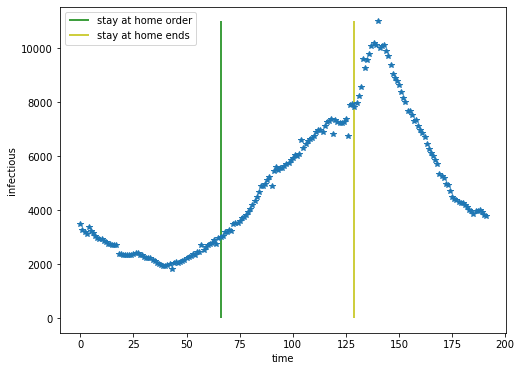

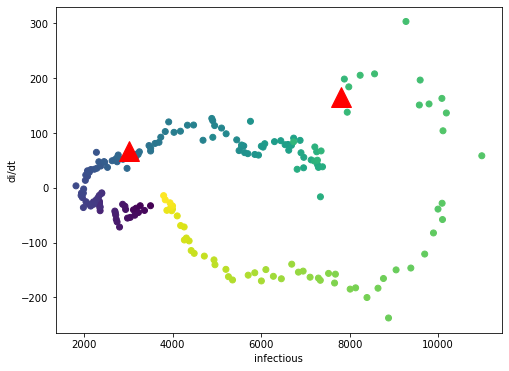

In [45]:
times = np.arange(len(infectious))
plt.figure(figsize=(8, 6))
plt.plot(times, infectious, "*")
plt.vlines(index_home[0], 0, np.max(infectious), "g", label="stay at home order")
try:
    plt.vlines(index_mask[0], 0, np.max(infectious), "r", label="mask mandate")
except:
    print("no mask mandate")

try:
    plt.vlines(index_out[0], 0, np.max(infectious), "y", label="stay at home ends")
except:
    print("no out time")
plt.xlabel("time")
plt.ylabel("infectious")
plt.legend()
plt.savefig("infectious.pdf")
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(infectious, infectious_rate, c=times)
plt.plot(infectious[index_home[0]], infectious_rate[index_home[0]], "r^",  
           markersize=20)
plt.plot(infectious[index_out[0]], infectious_rate[index_out[0]], "r^",  
           markersize=20)
plt.ylabel("di/dt")
plt.ylabel("di/dt")
plt.xlabel("infectious")
plt.savefig("spiral.pdf")
plt.show()



In [46]:
times = np.arange(len(rem))
sus_fit = sus / population
inf_fit = infectious / population
rem_fit = rem / population
sir_fitting = sir.moving_averages_fits(times, sus_fit, inf_fit, rem_fit, window=window, 
                                     opt_options={"method":"trust-constr", 
                                                                           "bounds": 
                                                                            [(1e-10, 100), (0, np.inf)]})

/home/jerome/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [47]:
print(sir_fitting)

[[1.33721025e+00 1.35148269e+00]
 [1.96432762e-01 7.53056764e-02]
 [1.51995404e-01 6.17754895e-03]
 [1.88948943e-01 1.88502009e-04]
 [1.82729804e+00 2.12278477e+00]
 [1.67440387e+00 1.93422623e+00]
 [1.52536170e+00 1.77760615e+00]
 [1.38330103e+00 1.58929904e+00]
 [1.36277944e+00 1.55561062e+00]
 [1.30231016e+00 1.45331574e+00]
 [1.49769311e+00 1.66048666e+00]
 [1.46455846e+00 1.61800759e+00]
 [1.42597623e+00 1.55624303e+00]]


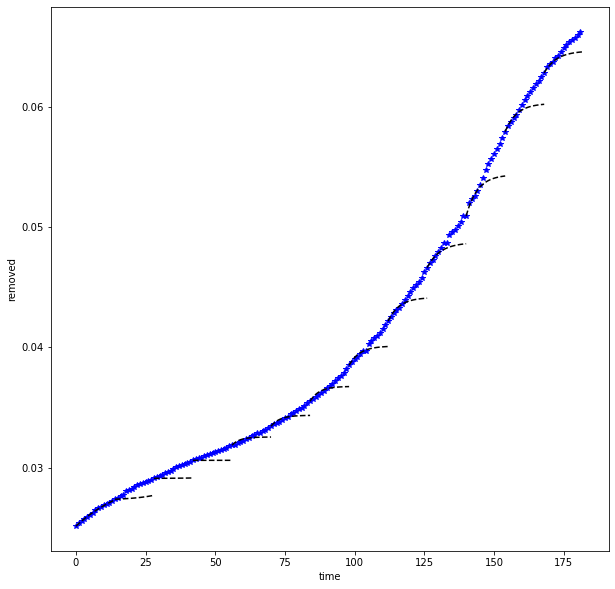

In [48]:
plt.figure(figsize=(10, 10))
for j in range(int(len(times) / window)):
    start = j * window
    stop = start + window
    plt.plot(times[start:stop], rem_fit[start:stop], "b*")
    sol = solve_ivp(sir.sir_ode, [times[start], times[stop]], 
                   [sus_fit[start], inf_fit[start], rem_fit[start]], 
                   args=sir_fitting[j, :], method="LSODA", max_step=0.25)
    plt.plot(sol.t, sol.y[2, :], "k--")
    
plt.xlabel("time")
plt.ylabel("removed")
plt.show()

In [49]:
row = mask_date_to_all_states(state_abbr, "all-states-history.csv", 'stay_at_home_and_masks.csv', 
                             item="stay_at_home_start")
bools = time_dataframe["date"] == np.array(row["date"])[0]
index_home = len(bools) - np.arange(len(bools))[bools]

try:
    row = mask_date_to_all_states(state_abbr, "all-states-history.csv", 'stay_at_home_and_masks.csv', 
                                 item="stay_at_home_end")
    bools = time_dataframe["date"] == np.array(row["date"])[0]
    index_out = len(bools) - np.arange(len(bools))[bools]
except:
    print("no stay at home end")

try:
    row = mask_date_to_all_states(state_abbr, "all-states-history.csv", 'stay_at_home_and_masks.csv', )
    bools = time_dataframe["date"] == np.array(row["date"])[0]
    index_mask = len(bools) - np.arange(len(bools))[bools]
except:
    index_mask = None

no mask mandate


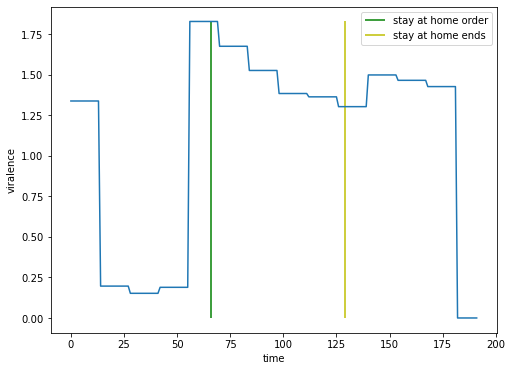

no mask mandate


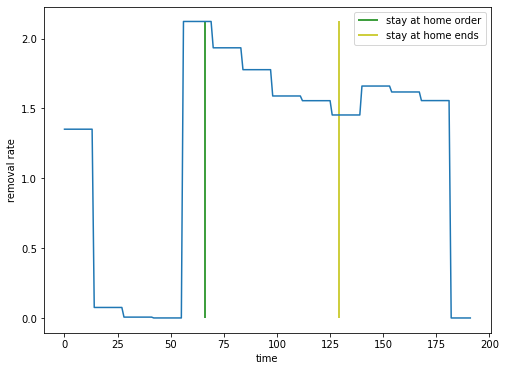

In [50]:
sir_fitting_plot = np.zeros([len(times), 2])
for j in range(int(len(times) / window)):
    sir_fitting_plot[j * window: j * window + window, :] = sir_fitting[j, :]
    
plt.figure(figsize=(8,6))
plt.plot(times, sir_fitting_plot[:, 0])
plt.vlines(index_home[0], 0, np.max(sir_fitting[:, 0]), "g", label="stay at home order")
try:
    plt.vlines(index_mask[0], 0, np.max(sir_fitting[:, 0]), "r", label="mask mandate")
except:
    print("no mask mandate")

try:
    plt.vlines(index_out[0], 0, np.max(sir_fitting[:, 0]), "y", label="stay at home ends")
except:
    print("no out time")
plt.xlabel("time")
plt.ylabel("viralence")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(times, sir_fitting_plot[:, 1])
plt.vlines(index_home[0], 0, np.max(sir_fitting[:, 1]), "g", label="stay at home order")
try:
    plt.vlines(index_mask[0], 0, np.max(sir_fitting[:, 1]), "r", label="mask mandate")
except:
    print("no mask mandate")

try:
    plt.vlines(index_out[0], 0, np.max(sir_fitting[:, 1]), "y", label="stay at home ends")
except:
    print("no out time")
plt.xlabel("time")
plt.ylabel("removal rate")
plt.legend()
plt.show()